# Dogs vs Cats Image Classification

## Summary of work

<p style="font-family:newtimeroman;color:#000000;font-size:130%;text-align:left;border-radius:30px 30px;">In this work, I will create a convolutional neural network to classify images of cats and dogs, using the cat and dog database in kaggle.</p>
    
<p style="font-family:newtimeroman;color:#000000;font-size:130%;text-align:left;border-radius:30px 30px;">First, a model will be created from scratch and the outputs and their metrics will be analyzed. Then the knowledge transfer method will be used, using the convolutional part of the pretrained network of Imagenet VGG16, to work several methods until the desired precision is achieved.</p>


<a id='top'></a>
    
## Table of Contents 
    
1. [IMPORTING LIBRARIES](#1)
    
2. [LOADING DATA](#2)
    
3. [DATA PREPROCESSING](#3) 
      
4. [MODEL SELECTION AND TRAINING](#4)

5. [GRANDCAM VISUALIZATION](#5)
    
6. [EVALUATING MODELS](#6)

    
    
<a id="1"></a>
# 1. Importing Libraries

In [1]:
import os, shutil, sys
import cv2
import skimage.io as io
from skimage.transform import resize
from PIL import Image

import numpy as np
import pandas as pd
from contextlib import contextmanager

import tensorflow as tf
from tensorflow import keras

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Nadam, RMSprop
from keras.applications import VGG16 
from keras.applications.vgg16 import preprocess_input 

from sklearn.metrics import confusion_matrix, roc_auc_score

%matplotlib inline
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard

<a id="2"></a>
# 2. Loading Data

<p style="font-family:newtimeroman;color:#000000;font-size:130%;text-align:left;border-radius:30px 30px;">We will start by importing the data and ordering it appropriately to be able to use a keras generator</p>



In [2]:
try:
    base_dir = '/kaggle/working'
    os.stat(base_dir)

    # Directorios de entrenamiento
    # validacion y evaluacion 
    os.mkdir("/kaggle/working/train")
    train_dir = os.path.join(base_dir, 'train')
    os.stat(train_dir)
    os.mkdir("/kaggle/working/validation")
    validation_dir = os.path.join(base_dir, 'validation')
    os.stat(validation_dir)
    os.mkdir("/kaggle/working/test")
    test_dir = os.path.join(base_dir, 'test')
    os.stat(test_dir)

    # Directorio entrenamiento de gatos (1000 imgs)
    os.mkdir(train_dir + '/cats')
    train_cats_dir = os.path.join(train_dir, 'cats')
    os.stat(train_cats_dir)

    # Directorio entrenamiento de perros (1000 imgs)
    os.mkdir(train_dir + '/dogs')
    train_dogs_dir = os.path.join(train_dir, 'dogs')
    os.stat(train_dogs_dir)

    # Directorio validacion de gatos (500 imgs)
    os.mkdir(validation_dir + '/cats')
    validation_cats_dir = os.path.join(validation_dir, 'cats')
    os.stat(validation_cats_dir)

    # Directorio validacion de perros (500 imgs)
    os.mkdir(validation_dir + '/dogs')
    validation_dogs_dir = os.path.join(validation_dir, 'dogs')
    os.stat(validation_dogs_dir)

    # Directorio validacion de gatos (500 imgs)
    os.mkdir(test_dir + '/cats')
    test_cats_dir = os.path.join(test_dir, 'cats')
    os.stat(test_cats_dir)

    # Directorio validacion de perros (500 imgs)
    os.mkdir(test_dir + '/dogs')
    test_dogs_dir = os.path.join(test_dir, 'dogs')
    os.stat(test_dogs_dir)
        
    print('Estructura de directorios completa')
    
except:
    print('Estructura de directorios incompleta')

Estructura de directorios completa


<p style="font-family:newtimeroman;color:#000000;font-size:130%;text-align:left;border-radius:30px 30px;">The data is extracted from the respective zip found in the inputs section of the notebook, and we supress the output of the code because its very large</p>

In [3]:
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

with suppress_stdout():
    ! unzip "../input/dogs-vs-cats/test1.zip" -d data_test

    ! unzip "../input/dogs-vs-cats/train.zip" -d data_train



In [4]:
print(os.listdir(base_dir + "/data_train"))
print(os.listdir(base_dir + "/data_test"))

['train']
['test1']


<p style="font-family:newtimeroman;color:#000000;font-size:130%;text-align:left;border-radius:30px 30px;">Now we copy the files from the folders extracted from the zip to the previously created folders</p>

In [5]:
base_dir = '/kaggle/working/'
path_data_train = os.path.join(base_dir, 'data_train/train/')
for p in os.listdir(path_data_train):
    if p.startswith('cat'):
        shutil.move(path_data_train+p, train_cats_dir)
    elif p.startswith('dog'):
        shutil.move(path_data_train+p, train_dogs_dir)

In [6]:
print('total training cat images:', len(os.listdir(train_cats_dir)))

total training cat images: 12500


<a id="3"></a>
# 3. Data Preprocessing

<p style="font-family:newtimeroman;color:#000000;font-size:130%;text-align:left;border-radius:30px 30px;">We will reduce the size of the database because the execution times can take a long time, but in case of obtaining more precision, the ideal would be to train the networks with all the data</p>

In [7]:
def mover(dir_from, dir_to, n):
    for i, p in enumerate(os.listdir(dir_from)):
        if i == n: break
        shutil.move(dir_from+'/'+p, dir_to)

def delete(dir, n):
    for i, p in enumerate(os.listdir(dir)):
        if i == n: break
        os.remove(dir+'/'+p)

def resize_local(dir):
    for p in os.listdir(dir):
        img = plt.imread(dir+'/'+p)
        img = cv2.resize(img, (150, 150))
        io.imsave(dir+'/'+p, img)
    


In [8]:
mover(train_cats_dir, test_cats_dir, 500)
mover(train_cats_dir, validation_cats_dir, 500)
mover(train_dogs_dir, test_dogs_dir, 500)
mover(train_dogs_dir, validation_dogs_dir, 500)

In [9]:
delete(train_cats_dir, 10500)
delete(train_dogs_dir, 10500)

In [10]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total testing cat images:', len(os.listdir(test_cats_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))

total training cat images: 1000
total testing cat images: 500
total validation cat images: 500


In [11]:
resize_local(train_cats_dir)
resize_local(train_dogs_dir)
resize_local(validation_cats_dir)
resize_local(validation_dogs_dir)
resize_local(test_cats_dir)
resize_local(test_dogs_dir)

<p style="font-family:newtimeroman;color:#000000;font-size:130%;text-align:left;border-radius:30px 30px;">A visualization of how the observations were after the preprocessing would be:</p>

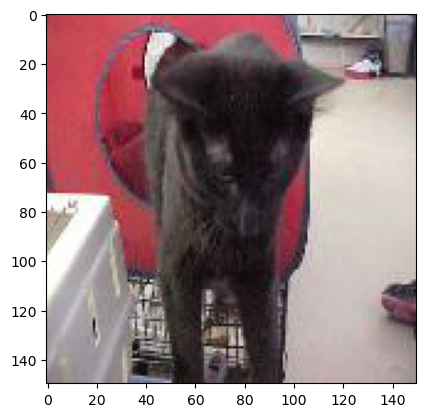

In [12]:
x = os.listdir(train_cats_dir)
plt.imshow(plt.imread(train_cats_dir + '/' + x[0])) 

<a id="4"></a>
# 4. Model Selection and Training

* <p style="font-family:newtimeroman;color:#000000;font-size:180%;text-align:left;border-radius:30px 30px;">Creation and Training of the Convolutional NN from scratch with keras</p>

<p style="font-family:newtimeroman;color:#000000;font-size:130%;text-align:left;border-radius:30px 30px;">We will start by creating a convolutional neural network from scratch to see what results it produces. The convolutional stage will consist of 4 main convolution layers and 4 pulling layers and the classification stage will have a layer of 562 neurons with `relu` activation function and the output layer with 1 neuron and `sigmoid` activation function, since is a binary classification problem</p>




In [13]:
model = Sequential()

model.add(Conv2D(32, (3, 3), 
                 activation='relu', 
                 input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(562, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

<p style="font-family:newtimeroman;color:#000000;font-size:130%;text-align:left;border-radius:30px 30px;">For the model, the `RSMprop` algorithm will be used with a learning rate of $10^{-4}$. The cost function will be binary crossentropy, since it is a binary classification problem.</p>


In [14]:
model.compile(loss='binary_crossentropy',
                optimizer= RMSprop(learning_rate=1e-4),
                metrics=['acc'])

<p style="font-family:newtimeroman;color:#000000;font-size:130%;text-align:left;border-radius:30px 30px;">The pixel values ​​of each photo are rescaled to values ​​between $[0, 1]$</p>

In [15]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Entrenamiento")
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

print("\n Validacion")

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Entrenamiento
Found 2000 images belonging to 2 classes.

 Validacion
Found 1000 images belonging to 2 classes.


In [16]:
history = model.fit(train_generator,steps_per_epoch=100,
                    epochs=30,
                    validation_data=validation_generator, 
                    validation_steps=50, verbose=1,
                    workers = 12)

Epoch 1/30
100/100 [==============================] - 16s 97ms/step - loss: 0.6910 - acc: 0.5440 - val_loss: 0.6716 - val_acc: 0.6260
Epoch 2/30
100/100 [==============================] - 9s 87ms/step - loss: 0.6670 - acc: 0.5905 - val_loss: 0.6473 - val_acc: 0.6440
Epoch 3/30
100/100 [==============================] - 9s 88ms/step - loss: 0.6264 - acc: 0.6390 - val_loss: 0.6392 - val_acc: 0.6200
Epoch 4/30
100/100 [==============================] - 9s 86ms/step - loss: 0.5913 - acc: 0.6795 - val_loss: 0.6268 - val_acc: 0.6450
Epoch 5/30
100/100 [==============================] - 9s 87ms/step - loss: 0.5611 - acc: 0.7060 - val_loss: 0.5870 - val_acc: 0.6840
Epoch 6/30
100/100 [==============================] - 9s 87ms/step - loss: 0.5281 - acc: 0.7365 - val_loss: 0.5804 - val_acc: 0.6810
Epoch 7/30
100/100 [==============================] - 9s 87ms/step - loss: 0.5054 - acc: 0.7485 - val_loss: 0.5804 - val_acc: 0.6910
Epoch 8/30
100/100 [==============================] - 5s 49ms/step -

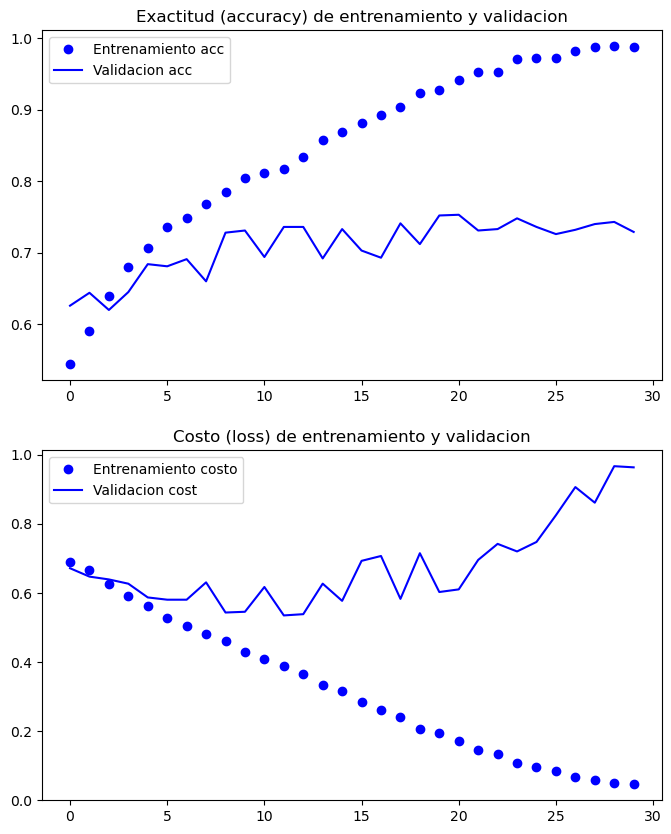

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(8,10))

plt.subplot(211)
plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validacion acc')
plt.title('Exactitud (accuracy) de entrenamiento y validacion')
plt.legend()

plt.subplot(212)
plt.plot(epochs, loss, 'bo', label='Entrenamiento costo')
plt.plot(epochs, val_loss, 'b', label='Validacion cost')
plt.title('Costo (loss) de entrenamiento y validacion')
plt.legend()

plt.show()

<p style="font-family:newtimeroman;color:#000000;font-size:130%;text-align:left;border-radius:30px 30px;">An overfitting can be observed in the graphs, it was something to be expected, since data augmentation was not even applied to the observations, only the pixel values were rescaled.</p>



* <p style="font-family:newtimeroman;color:#000000;font-size:180%;text-align:left;border-radius:30px 30px;">Offline Trait Extractor</p>

<p style="font-family:newtimeroman;color:#000000;font-size:130%;text-align:left;border-radius:30px 30px;">To test another strategy, we will use knowledge transfer with the `VGG16` network of `Imagnet`. As a first strategy, the Pretrained Network will be applied as an extractor of off-line features, that is, all the convolutional layers of the pretrained network will be applied to the data to then create a new dataset and manually define the classification stage, as a multilayer perceptron.</p>


In [18]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

58889256/58889256 [==============================] - 0s 0us/step
Found 2000 images belonging to 2 classes.
1/1 [==============================] - 0s 24ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 23ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 22ms/step


In [19]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs          = 30,
                    batch_size      = 20,
                    validation_data = (validation_features, validation_labels),
                    verbose         = 2)

Epoch 1/30
100/100 - 1s - loss: 1.3811 - acc: 0.8575 - val_loss: 0.7074 - val_acc: 0.9230 - 979ms/epoch - 10ms/step
Epoch 2/30
100/100 - 0s - loss: 0.2583 - acc: 0.9585 - val_loss: 0.6493 - val_acc: 0.9320 - 377ms/epoch - 4ms/step
Epoch 3/30
100/100 - 0s - loss: 0.0554 - acc: 0.9920 - val_loss: 0.6044 - val_acc: 0.9350 - 360ms/epoch - 4ms/step
Epoch 4/30
100/100 - 0s - loss: 0.0097 - acc: 0.9985 - val_loss: 0.6034 - val_acc: 0.9330 - 379ms/epoch - 4ms/step
Epoch 5/30
100/100 - 0s - loss: 7.8373e-04 - acc: 0.9995 - val_loss: 0.5538 - val_acc: 0.9410 - 327ms/epoch - 3ms/step
Epoch 6/30
100/100 - 0s - loss: 1.2670e-05 - acc: 1.0000 - val_loss: 0.5830 - val_acc: 0.9380 - 321ms/epoch - 3ms/step
Epoch 7/30
100/100 - 0s - loss: 1.4610e-06 - acc: 1.0000 - val_loss: 0.5456 - val_acc: 0.9450 - 372ms/epoch - 4ms/step
Epoch 8/30
100/100 - 0s - loss: 1.1804e-07 - acc: 1.0000 - val_loss: 0.5608 - val_acc: 0.9440 - 318ms/epoch - 3ms/step
Epoch 9/30
100/100 - 0s - loss: 1.6552e-08 - acc: 1.0000 - val_

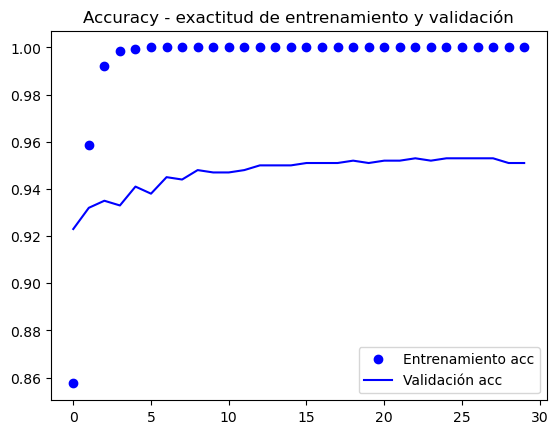

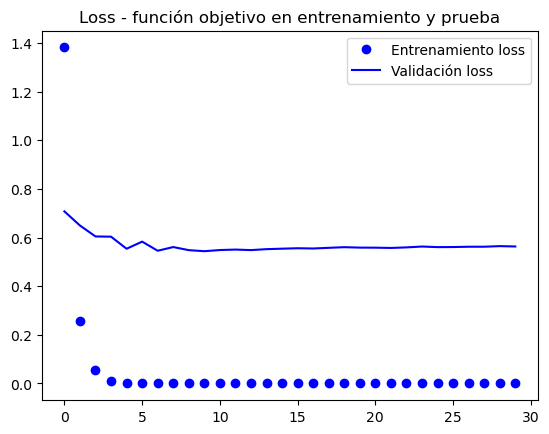

In [20]:
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

* <p style="font-family:newtimeroman;color:#000000;font-size:180%;text-align:left;border-radius:30px 30px;">Frozen Convolutional Training</p>

<p style="font-family:newtimeroman;color:#000000;font-size:130%;text-align:left;border-radius:30px 30px;">Now to see if the precision of the model increases further, we will take the convolutional stage of the neural network and leave it fixed, but we will train the entire model, passing the data in each epoch through the convolutional stage of the pretrained network, with frozen parameters.</p>

In [21]:
conv_base.trainable = False

model = Sequential()
model.add(conv_base)        # modelo base agradado como una capa!
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation='softmax'))

In [22]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range    = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range= 0.2,
                                   shear_range       = 0.2,
                                   zoom_range        = 0.2,
                                   horizontal_flip   = True,
                                   fill_mode         = 'constant',
                                   cval              = 0)

# La validación no se aumenta!
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
                        train_dir,                # directorio con datos de entrenamiento
                        target_size= (150, 150),  # tamaño de la imágenes 
                        batch_size = 20,   
                        shuffle    = True,
                        class_mode = 'categorical')    # para clasificación binaria

validation_generator = test_datagen.flow_from_directory(
                        validation_dir,
                        target_size=(150, 150),
                        batch_size=20,
                        shuffle = False,
                        class_mode='categorical')

model.compile(loss='categorical_crossentropy',
              optimizer= Nadam(learning_rate=2e-5), #optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [23]:
history = model.fit(train_generator,
                    steps_per_epoch = 100, 
                    epochs          = 30,
                    validation_data = validation_generator,
                    validation_steps= 50,
                    verbose         = 1)

Epoch 1/30
100/100 [==============================] - 14s 130ms/step - loss: 3.5509 - acc: 0.7350 - val_loss: 1.2271 - val_acc: 0.9030
Epoch 2/30
100/100 [==============================] - 12s 124ms/step - loss: 1.6379 - acc: 0.8420 - val_loss: 1.0668 - val_acc: 0.9220
Epoch 3/30
100/100 [==============================] - 13s 127ms/step - loss: 1.4402 - acc: 0.8665 - val_loss: 0.8814 - val_acc: 0.9340
Epoch 4/30
100/100 [==============================] - 12s 123ms/step - loss: 1.0635 - acc: 0.8950 - val_loss: 0.8326 - val_acc: 0.9370
Epoch 5/30
100/100 [==============================] - 13s 132ms/step - loss: 1.0840 - acc: 0.8940 - val_loss: 0.7939 - val_acc: 0.9380
Epoch 6/30
100/100 [==============================] - 13s 126ms/step - loss: 1.0213 - acc: 0.9040 - val_loss: 0.6795 - val_acc: 0.9430
Epoch 7/30
100/100 [==============================] - 12s 123ms/step - loss: 0.9178 - acc: 0.8980 - val_loss: 0.6539 - val_acc: 0.9490
Epoch 8/30
100/100 [==============================] - 1

<p style="font-family:newtimeroman;color:#000000;font-size:130%;text-align:left;border-radius:30px 30px;">Even more precision is achieved than the previous model</p>

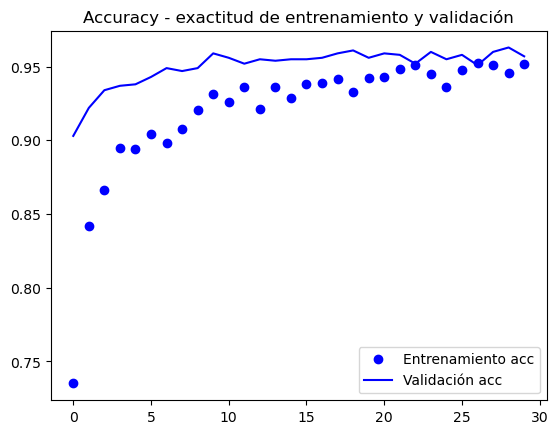

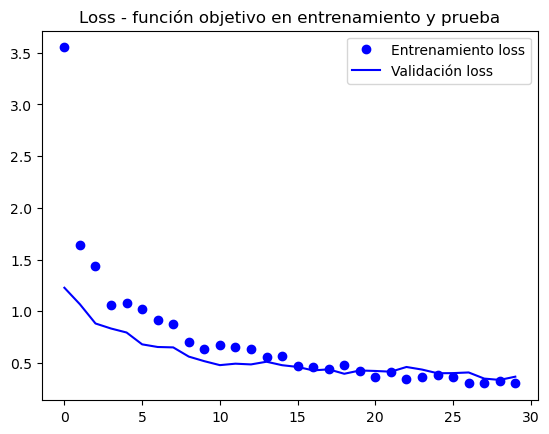

In [24]:
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

* <p style="font-family:newtimeroman;color:#000000;font-size:180%;text-align:left;border-radius:30px 30px;">Fine tuning</p>

<p style="font-family:newtimeroman;color:#000000;font-size:130%;text-align:left;border-radius:30px 30px;">Now we will perform a fine adjustment to the last 3 convolution layers of the `VGG16` network:</p>
  
1. `block5_conv2`
2. `block5_conv3`
3. `block5_pool`

<p style="font-family:newtimeroman;color:#000000;font-size:130%;text-align:left;border-radius:30px 30px;">Finally we will train the model, with the same classification stage used in all the other two models.</p>


In [25]:
conv_base.trainable = True

for layer in conv_base.layers:
    if layer.name in ['block5_conv1','block5_conv2','block5_conv3']:
        layer.trainable = True
    else:
        layer.trainable = False       

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=1e-5),
              metrics=['acc'])

In [26]:
history = model.fit(train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 14s 126ms/step - loss: 0.3121 - acc: 0.9435 - val_loss: 0.3388 - val_acc: 0.9580
Epoch 2/100
100/100 [==============================] - 13s 132ms/step - loss: 0.2859 - acc: 0.9455 - val_loss: 0.4646 - val_acc: 0.9470
Epoch 3/100
100/100 [==============================] - 12s 123ms/step - loss: 0.2225 - acc: 0.9545 - val_loss: 0.3411 - val_acc: 0.9570
Epoch 4/100
100/100 [==============================] - 13s 130ms/step - loss: 0.2553 - acc: 0.9525 - val_loss: 0.3264 - val_acc: 0.9580
Epoch 5/100
100/100 [==============================] - 12s 124ms/step - loss: 0.1978 - acc: 0.9590 - val_loss: 0.3079 - val_acc: 0.9600
Epoch 6/100
100/100 [==============================] - 12s 125ms/step - loss: 0.1748 - acc: 0.9560 - val_loss: 0.3010 - val_acc: 0.9610
Epoch 7/100
100/100 [==============================] - 13s 129ms/step - loss: 0.1971 - acc: 0.9590 - val_loss: 0.3333 - val_acc: 0.9630
Epoch 8/100
100/100 [===========================

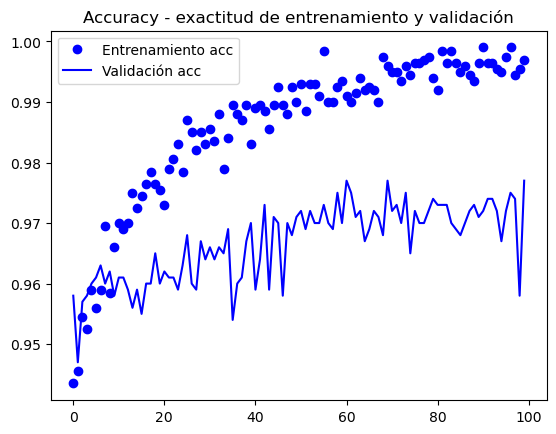

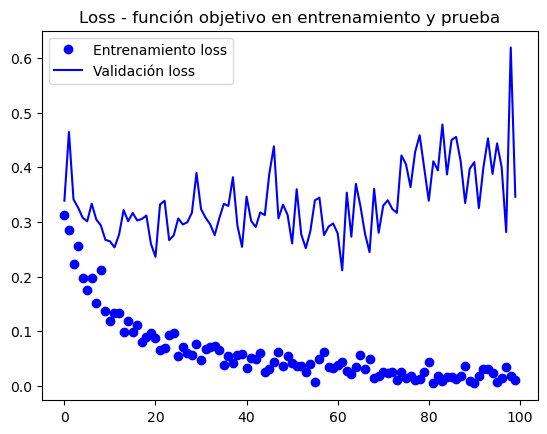

In [27]:
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

<p style="font-family:newtimeroman;color:#000000;font-size:130%;text-align:left;border-radius:30px 30px;">Since the curves are very noisy, it is possible to filter them to better appreciate the trend by means of a low pass filter, one could try</p>

$$\hat s_i = \sum_{k = 0}^{n}w_k s_{i - k}$$

<p style="font-family:newtimeroman;color:#000000;font-size:130%;text-align:left;border-radius:30px 30px;">where $w$ are the weights with $\sum_{k}w_k = 1$ but we would need to use a fairly wide filter ($n$ large) to properly remove noise, instead let's try the recursive version</p>

$$\hat s = \alpha\hat s_{i - 1} + (1 - \alpha)\hat s_i$$

<p style="font-family:newtimeroman;color:#000000;font-size:130%;text-align:left;border-radius:30px 30px;">that is, a convex linear combination of the points</p>

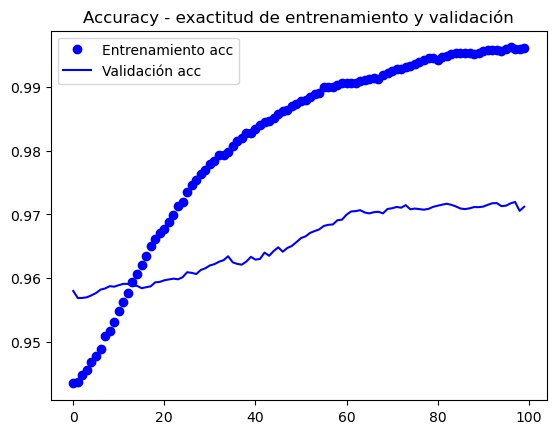

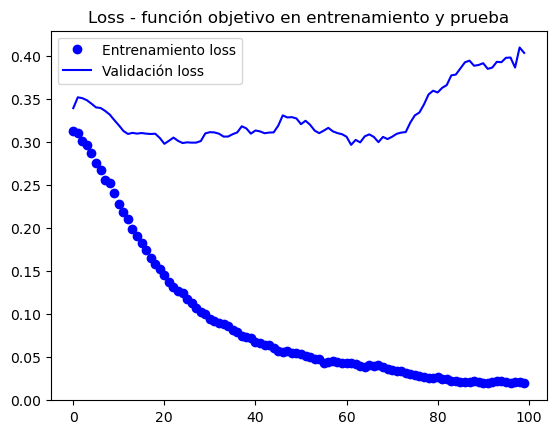

In [28]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
alpha = 0.9

plt.plot(epochs, smooth_curve(acc,     alpha), 'bo', label='Entrenamiento acc')
plt.plot(epochs, smooth_curve(val_acc, alpha), 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss,    alpha), 'bo', label='Entrenamiento loss')
plt.plot(epochs, smooth_curve(val_loss,alpha), 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

<p style="font-family:newtimeroman;color:#000000;font-size:130%;text-align:left;border-radius:30px 30px;">In these curves you can better appreciate the trend, we can see that there was an improvement of around 1%. It is necessary to appreciate that the accuracy is improving even when the loss is not. This is because the loss is evaluated by a process of summation of errors in the output vector, something like:</p>

$$\sum_{i \in epocs}||y_i - \hat y_i||$$

<p style="font-family:newtimeroman;color:#000000;font-size:130%;text-align:left;border-radius:30px 30px;">instead the accuracy is calculated by a sum of classification errors:</p>

$$\sum_{i \in epocs}1 - \delta(\arg \max_i y_i - \arg \max_i \hat y_i )$$



<a id="5"></a>
# 5. GrandCAM visualizations

<p style="font-family:newtimeroman;color:#000000;font-size:130%;text-align:left;border-radius:30px 30px;">GranCAM (Gradient-weighted Class Activation Mapping) visualizations are a convolutional neural network (ConvNN) visualization technique that allows us to understand which parts of an image are relevant for network decision making.</p>

<p style="font-family:newtimeroman;color:#000000;font-size:130%;text-align:left;border-radius:30px 30px;">This technique uses gradient backpropagation to calculate the importance of each image pixel in the final classification performed by the neural network. These importances are then applied as weights on a weighted sum of the activations of the last convolutional layer of the network, resulting in a heat map image showing the areas of the image that most influence the classification of the network. .</p>

<p style="font-family:newtimeroman;color:#000000;font-size:130%;text-align:left;border-radius:30px 30px;">In this way, GranCAM visualizations allow a more intuitive interpretation of the output of a convolutional neural network, which can be useful for model analysis and debugging, as well as for understanding network decision making in case artificial intelligence applications in the real world.</p>

<p style="font-family:newtimeroman;color:#000000;font-size:130%;text-align:left;border-radius:30px 30px;">Firstly we will define the function that will calculate the probability map, and the saliency, which is no more than the average response of the last convolutional layer </p>



In [50]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    
    last_conv_layer  = model.get_layer(last_conv_layer_name)
    conv_model       = keras.Model(last_conv_layer.inputs, last_conv_layer.output)
    
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)
         
    with tf.GradientTape() as tape:
        last_conv_layer_output = conv_model(img_array)
        tape.watch(last_conv_layer_output)
        
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]
        
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    
    saliency = np.mean(last_conv_layer_output, axis=-1)
    saliency = np.maximum(saliency, 0) / np.max(saliency)
    
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
        
    grad_cam = np.mean(last_conv_layer_output, axis=-1)
    grad_cam = np.maximum(grad_cam, 0)/ np.max(grad_cam)
    
    return grad_cam, saliency

<p style="font-family:newtimeroman;color:#000000;font-size:130%;text-align:left;border-radius:30px 30px;">We load any photo from the test set and convert it to a numpy array</p>

In [ ]:
def get_img_array(img_path):
    
    img = Image.open(img_path)
    img = img.resize(size=(150, 150))
    
    print(f'format: {img.format}, shape: {img.size}, mode: {img.mode}')
    img_array = np.array(img).astype('float32')[:,:,:3]  # tiramos el canal alpha
    print(img_array.shape)
    img_array = np.expand_dims(img_array, axis=0)
    print(img_array.shape)
    return img, img_array

format: None, shape: (150, 150), mode: RGB
(150, 150, 3)
(1, 150, 150, 3)


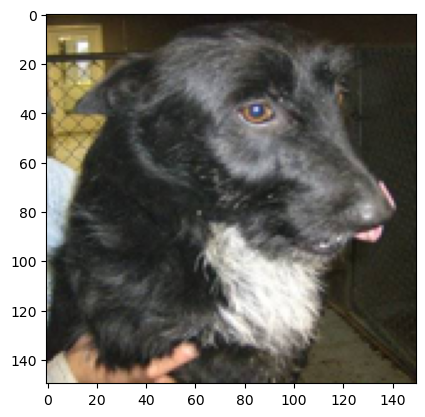

                  GradCAM: 

[[0.02883667 0.21389265 0.09845863 0.        ]
 [0.10517961 0.5782156  1.         0.78155786]
 [0.05478355 0.50918114 0.9317538  0.6368116 ]
 [0.05673404 0.13147725 0.10758816 0.        ]]


In [91]:
last_conv_layer_name   = model.layers[0].name
classifier_layer_names = []
for i in range(1, len(model.layers)):
    classifier_layer_names.append(model.layers[i].name)

# This is because there are a few pictures that have problem with my function,
# and I have to run all notebook, so I simply search the first that is compatible
data_dir = '/kaggle/working/data_test/test1'
i = 0
while True:
    img_path = os.path.join(data_dir, os.listdir(data_dir)[i])
    img,img_array =  get_img_array(img_path = img_path)
    grad_cam, saliency = make_gradcam_heatmap(img_array, 
                                           model, 
                                           last_conv_layer_name, 
                                           classifier_layer_names)
    if not np.all(np.isnan(grad_cam)): break
    i += 1
    
plt.imshow(img)
plt.show()

print("                  GradCAM: \n")
print(grad_cam)    

In [85]:
img_array = preprocess_input(img_array)
preds = model.predict(img_array, verbose=1)
preds

1/1 [==============================] - 0s 20ms/step


array([[1.3045123e-26, 1.0000000e+00]], dtype=float32)

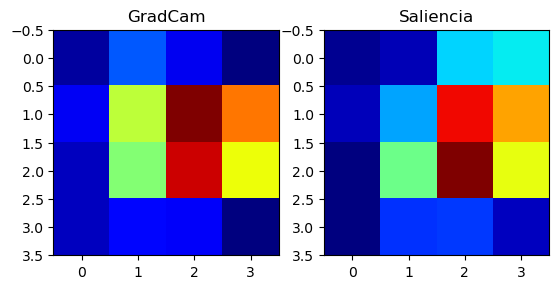

In [86]:
def show_hotmap(img, heatmap, title='Heatmap', alpha=0.6, cmap='jet', axisOnOff='off'):
    
    resized_heatmap=resize(heatmap, img.size)
    
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.imshow(resized_heatmap, alpha=alpha, cmap=cmap)
    plt.axis(axisOnOff)
    plt.title(title)
    plt.show()
    
plt.subplot(121)
plt.imshow(grad_cam, 'jet')
plt.title('GradCam')
plt.subplot(122)
plt.imshow(saliency, 'jet')
plt.title('Saliencia')
plt.show()


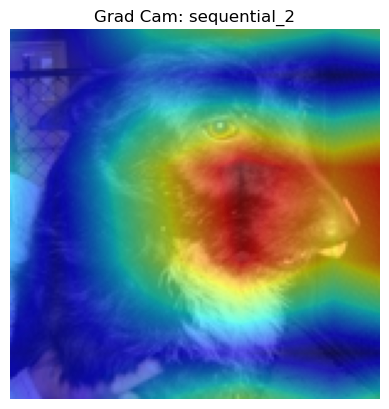

In [87]:
show_hotmap(img=img, heatmap=grad_cam, title=f'Grad Cam: {model.name}')

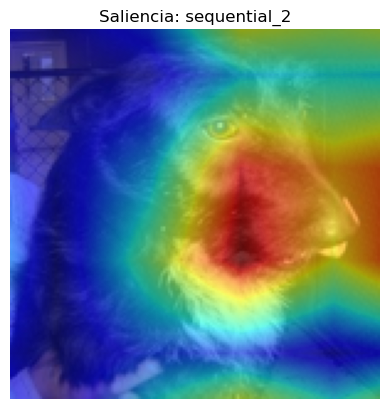

In [83]:
show_hotmap(img=img, heatmap=saliency, title=f'Saliencia: {model.name}')

<p style="font-family:newtimeroman;color:#000000;font-size:130%;text-align:left;border-radius:30px 30px;">Note how GradCam effectively displays the activation map for the selected class, in our example we automatically select the one with the highest probability. While the saliency shows the heat maps for the most probable classes.</p>




<a id="6"></a>
# 6. Evaluating Models

<p style="font-family:newtimeroman;color:#000000;font-size:130%;text-align:left;border-radius:30px 30px;">For the model evaluation process, the following metrics will be calculated based on the confusion matrix</p>

1. `Accuracy`  
2. `Sensitivity` (o recall)
3. `Specificity`
4. `Presicion`
5. `Confussion Matrix`
6. `AUC-ROC` (area under the curve ROC)

In [43]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        shuffle = False,
        class_mode='categorical')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 2s 35ms/step - loss: 0.3821 - acc: 0.9740
test acc: 0.9739999771118164


In [44]:
y_pred = model.predict(test_generator, verbose=1)
y_true = test_generator.classes

conf_mat = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
print('Confusion matrix:')
print(conf_mat)

accuracy = (conf_mat[0,0]+conf_mat[1,1])/sum(sum(conf_mat))
print('Accuracy:', accuracy)

specificity = conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
print('Specificity:', specificity)

recall = conf_mat[1,1]/(conf_mat[1,0]+conf_mat[1,1])
print('Sensitivity:', recall)

precision = conf_mat[1,1]/(conf_mat[0,1]+conf_mat[1,1])
print('Precision:', precision)

AUC = roc_auc_score(y_true, y_pred[:,1])
print('AUC-ROC:', AUC)

50/50 [==============================] - 2s 30ms/step
Confusion matrix:
[[488  12]
 [ 14 486]]
Accuracy: 0.974
Specificity: 0.976
Sensitivity: 0.972
Precision: 0.9759036144578314
AUC-ROC: 0.993066
